# Track Woody Cover Fraction Through Time

You will need:
- The WCF model
- A polygon for the area of interest

The steps are:
1. Import necessary modules
2. Import data
    - Import your polygon
    - Load satellite data occurring at the polygon
3. Calculate WCF
    - Import WCF model
    - Calculate WCF
4. Calculate statistics over polygon
    - Save as csv

### 1. Import modules

In [3]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/Stuff_for_Richard'

In [5]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import rasterio

from scipy import stats
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

from datacube.utils import geometry # needed to turn shapefile into queriable geometry
from rasterio import features # needed to convert polygon into raster for masking

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten
import dea_plotting
from dea_plotting import display_map
from dea_plotting import rgb

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [6]:
dc = datacube.Datacube()

### 2. Import data

#### Shapefile

Sort out the shapefile first so that it can be used to load the satellite data

In [9]:
# Loading a shapefile as a geopandas dataframe
#gb = gpd.read_file('Inputs/GKP/GKP_EPSG_4326_VICNSW.shp')  # use address of shapefile in jupyter notebooks, using 'pwd' in another cell can help
gb = gpd.read_file('Inputs/GKP/GKP_Extent.shp')  # use address of shapefile in jupyter notebooks, using 'pwd' in another cell can help
gb

,MINX,MINY,MAXX,MAXY,CNTX,CNTY,AREA,PERIM,HEIGHT,WIDTH,geometry
0,1090000.0,-3980000.0,1130000.0,-3930000.0,1110000.0,-3955000.0,2.000000e+09,180000.0,50000.0,40000.0,"POLYGON ((1090000.000 -3980000.000, 1090000.00..."


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


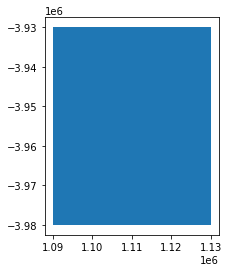

In [10]:
# Re-project polygon to match desired output CRS if necessary and plot
gb = gb.to_crs({'init': 'EPSG:3577'})
gb.plot()

In [11]:
# Use the polygon to create a custom datacube geometry object based on 
# geojson and projection. This is used as in input to the datacube load.
gb3577 = gb.to_crs({'init': 'EPSG:3577'})
geom = geometry.Geometry(gb3577.iloc[0].geometry.__geo_interface__,crs=geometry.CRS('EPSG:3577'))
print(geom)

Geometry({'type': 'Polygon', 'coordinates': (((1090000.0, -3980000.0), (1090000.0, -3930000.0), (1130000.0, -3930000.0), (1130000.0, -3980000.0), (1090000.0, -3980000.0)),)}, CRS('EPSG:3577'))


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Satellite data

Define parameters

In [12]:
# Define the aoi
# lat = (-27.8, -28.0)
# lon = (145.3, 145.7)

bounds = gb.total_bounds
minx = bounds[0]
maxx = bounds[2]
miny = bounds[1]
maxy = bounds[3]
lon = (minx, maxx)
lat = (miny, maxy)

# Filter date
time = ('2010-01-01', '2015-12-31')

# Choose products to load
# Here, the ARD landsat data is chosen
products = ['ga_ls8c_ard_3']

In [14]:
# Check location
display_map(x=lon, y=lat, crs='EPSG:3577')

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

Create the query

In [15]:
# Specify the parameters to pass to the load query
query = {
#     "x": lon,
#     "y": lat,
    "geopolygon":geom,
    "time": time,
    # Make sure the order is correct for the model: blue, green, red, nir, swir1 and swir2 
    "measurements": ["nbart_blue", "nbart_green", "nbart_red", "nbart_nir", "nbart_swir_1", "nbart_swir_2"],
    "output_crs": 'EPSG:3577',
    "resolution": (-30, 30)
}

Import the data

In [16]:
# Load the data
ds = load_ard(dc, products=products, min_gooddata=0.1, **query)
ds

Loading ga_ls8c_ard_3 data
    Filtering to 136 out of 175 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 136 observations 


<xarray.Dataset>
Dimensions:       (time: 136, x: 1334, y: 1667)
Coordinates:
    spatial_ref   int32 3577
  * y             (y) float64 -3.93e+06 -3.93e+06 ... -3.98e+06 -3.98e+06
  * x             (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.13e+06 1.13e+06
  * time          (time) datetime64[ns] 2013-03-26T00:10:28.646614 ... 2015-12-26T00:09:22.292378
Data variables:
    nbart_blue    (time, y, x) float32 1071.0 1110.0 1141.0 ... 907.0 891.0
    nbart_green   (time, y, x) float32 1774.0 1820.0 1833.0 ... 1289.0 1276.0
    nbart_red     (time, y, x) float32 2644.0 2693.0 2734.0 ... 1899.0 1904.0
    nbart_nir     (time, y, x) float32 3666.0 3739.0 3775.0 ... 3185.0 3175.0
    nbart_swir_1  (time, y, x) float32 4835.0 4866.0 4898.0 ... 3236.0 3341.0
    nbart_swir_2  (time, y, x) float32 4229.0 4226.0 4263.0 ... 2171.0 2263.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

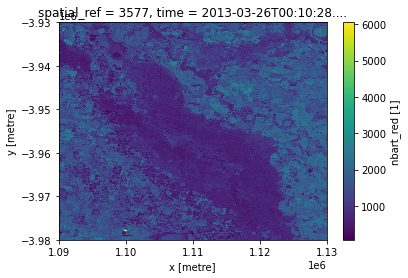

In [17]:
# Check by plotting
ds.isel(time=0).nbart_red.plot()

### 3. Calculate wcf

In [22]:
#### Import wcf model
pickle_in = open('wcf_model.pickle','rb')
model = pickle.load(pickle_in)
model

/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid resul

RandomForestRegressor(ccp_alpha=None, min_samples_leaf=50, random_state=20)

In [23]:
#### Define a function to format image and run model over it
def predict_wcf(image,model):
    flat = sklearn_flatten(image)
    flat = flat/10000
    results = model.predict(flat)
    print('Results:',results)
    unflat = (sklearn_unflatten(results,image).transpose())[0]
    return unflat

In [24]:
# Rename bands (although this shouldn't make a difference, the order is most important)
ds_rename = ds.rename({'nbart_blue': 'blue','nbart_green': 'green','nbart_red':'red','nbart_nir':'nir','nbart_swir_1':'swir1','nbart_swir_2':'swir2'})
ds_rename

<xarray.Dataset>
Dimensions:      (time: 136, x: 1334, y: 1667)
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -3.93e+06 -3.93e+06 ... -3.98e+06 -3.98e+06
  * x            (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.13e+06 1.13e+06
  * time         (time) datetime64[ns] 2013-03-26T00:10:28.646614 ... 2015-12-26T00:09:22.292378
Data variables:
    blue         (time, y, x) float32 1071.0 1110.0 1141.0 ... 875.0 907.0 891.0
    green        (time, y, x) float32 1774.0 1820.0 1833.0 ... 1289.0 1276.0
    red          (time, y, x) float32 2644.0 2693.0 2734.0 ... 1899.0 1904.0
    nir          (time, y, x) float32 3666.0 3739.0 3775.0 ... 3185.0 3175.0
    swir1        (time, y, x) float32 4835.0 4866.0 4898.0 ... 3236.0 3341.0
    swir2        (time, y, x) float32 4229.0 4226.0 4263.0 ... 2171.0 2263.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [25]:
rank_norm_list = []

times = list(range(list(ds.dims.values())[0]))

# Loop through all the times
for i in times:
    
    # Select that time
    ds_t = ds.isel(time=i).expand_dims('time')
    
    # Apply the WCF model to that time
    rank_norm_t = predict_wcf(ds_t,model)
    rank_norm_list.append(rank_norm_t)

# After the loop re-combine the DataArrays
rank_norm = xr.combine_nested(rank_norm_list, concat_dim=['time']).to_dataset(name='wcf')
rank_norm

Results: [0.00246678 0.00065024 0.00069476 ... 0.00024401 0.00013722 0.0002021 ]
Results: [0.00260831 0.00075687 0.00063595 ... 0.01429068 0.0139662  0.01247   ]
Results: [0.00250254 0.00063393 0.00037567 ... 0.02111541 0.02111541 0.01360108]
Results: [0.00260831 0.00037567 0.00031787 ... 0.00737744 0.00414151 0.00577533]
Results: [0.00277711 0.0009669  0.00078306 ... 0.01439036 0.00718208 0.00576592]
Results: [0.11113597 0.10718072 0.10621685 ... 0.00819048 0.00367218 0.0040047 ]
Results: [0.01990918 0.01842931 0.01804949 ... 0.41047875 0.40344773 0.43278918]
Results: [0.02085604 0.01939956 0.01911709 ... 0.41855734 0.40132316 0.45815086]
Results: [0.45009206 0.26117743 0.54243686 ... 0.0915354  0.0915354  0.0972636 ]
Results: [0.01699447 0.01687851 0.01678223 ... 0.2035662  0.15618401 0.22864425]
Results: [0.01678402 0.01672952 0.01694069 ... 0.21207778 0.15541563 0.25091387]
Results: [0.26065921 0.24920139 0.22284361 ... 0.0972636  0.11470578 0.13804449]
Results: [9.26723864e-05 5.0

<xarray.Dataset>
Dimensions:  (time: 136, x: 1334, y: 1667)
Coordinates:
  * y        (y) float64 -3.93e+06 -3.93e+06 -3.93e+06 ... -3.98e+06 -3.98e+06
  * x        (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.13e+06 1.13e+06
  * time     (time) datetime64[ns] 2013-03-26T00:10:28.646614 ... 2015-12-26T00:09:22.292378
Data variables:
    wcf      (time, y, x) float64 0.002467 0.00273 0.003737 ... 0.02111 0.01055

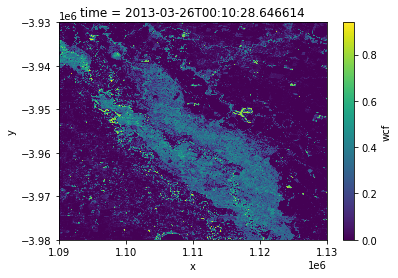

In [26]:
# Plot just to check
rank_norm.wcf.isel(time=0).plot()

### 4. Calculate statistics

In [27]:
wcf = rank_norm.wcf

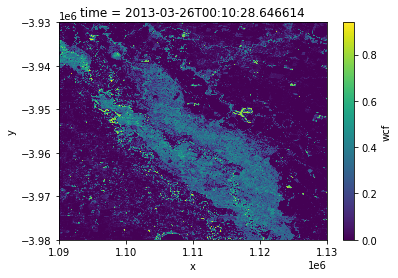

In [35]:
# Mask area outside of polygon - remember we loaded data for the complete bounding box
mask = rasterio.features.rasterize(shapes=[(gb3577.iloc[0].geometry, 1)],
                                   out_shape=(ds.dims['y'], ds.dims['x']),
                                   transform=ds.geobox.transform)

# Apply raster mask to dataset. This will automatically apply the mask to 
# all timesteps and bands in the dataset.
wcf_masked = wcf.where(mask)

# Plot a single timestep in RGB to verify that data outside the polygon has been masked out
wcf_masked.isel(time=0).plot()

In [29]:
# Calculate mean WCF
mean = wcf_masked.mean(dim=['x', 'y'])

# Add to a single dataframe ready to be written out as a CSV with time as an index
mean_df = pd.DataFrame(data={'wcf_mean_2019': mean}, index=wcf.time.values)

# Write to file
mean_df.to_csv(f'wcf_mean_2019{time[0]}-{time[1]}.csv', index_label='time')

# Preview data
mean_df.head()

,wcf_mean_2019
2013-03-26 00:10:28.646614,0.107981
2013-04-15 00:16:50.541243,0.083135
2013-04-15 00:17:14.499095,0.145966
2013-05-17 00:17:00.610262,0.110541
2013-05-17 00:17:24.550223,0.178615


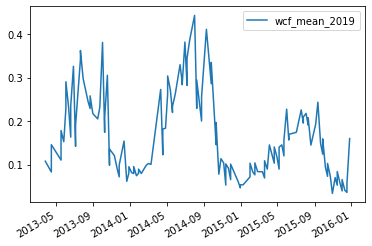

In [30]:
# Plot the trace through time
mean_df.plot()

In [33]:
mature_floodpln_euc_xarray

NameError: name 'mature_floodpln_euc_xarray' is not defined

ImportError: cannot import name 'export_to_geotiff'

In [31]:
# Export data as a GeoTiff
export_to_geotiff(mature_floodpln_euc_xarray, "outputs/{}_{}-WCW.tif".format(site_name.replace(" ","_"), year))

from datacube.utils import cog
cog.write_cog()

NameError: name 'export_to_geotiff' is not defined

In [32]:
from dea_datahandling import array_to_geotiff
for i in range(len(wcf_masked.time)):
 
    # We will use the date of the satellite image to name the GeoTIFF
    date = str(wcf_masked.isel(time=i).time.data)[:-19]
    print(f'Writing {date}')
   
    array_to_geotiff(f"wcf_file_{date}.tif", wcf_masked.isel(time=i).values,
                     geo_transform=ds.geobox.transform.to_gdal(),
                     projection=ds.geobox.crs.wkt)

Writing 2013-03-26
Writing 2013-04-15
Writing 2013-04-15
Writing 2013-05-17
Writing 2013-05-17
Writing 2013-05-26
Writing 2013-06-02
Writing 2013-06-02
Writing 2013-06-11
Writing 2013-06-18
Writing 2013-06-18
Writing 2013-06-27
Writing 2013-07-04
Writing 2013-07-04
Writing 2013-07-20
Writing 2013-07-20
Writing 2013-07-29
Writing 2013-08-14
Writing 2013-08-21
Writing 2013-08-21
Writing 2013-08-30
Writing 2013-09-15
Writing 2013-09-22
Writing 2013-10-01
Writing 2013-10-08
Writing 2013-10-08
Writing 2013-10-17
Writing 2013-10-24
Writing 2013-10-24
Writing 2013-11-09
Writing 2013-11-18
Writing 2013-11-25
Writing 2013-11-25
Writing 2013-12-11
Writing 2013-12-20
Writing 2013-12-27
Writing 2013-12-27
Writing 2014-01-05
Writing 2014-01-12
Writing 2014-01-12
Writing 2014-01-21
Writing 2014-01-28
Writing 2014-01-28
Writing 2014-02-06
Writing 2014-02-22
Writing 2014-03-01
Writing 2014-03-10
Writing 2014-04-11
Writing 2014-04-18
Writing 2014-04-18
Writing 2014-04-27
Writing 2014-05-04
Writing 2014